# Spectroscopic overlaps

__Date:__ February 21, 2024

Testing spectroscopic overlaps $\langle \Psi^{A-1}_{\alpha} \lvert a_{\mathbf{q \sigma \tau}} \rvert \Psi^A_0 \rangle$ using SRG transformations.

_Last update:_ April 23, 2024

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.special import sph_harm, spherical_jn
from sympy.physics.quantum.cg import CG

In [2]:
# Imports from scripts
from spectroscopic_overlaps_vegas import SpectroscopicOverlap as SO
from scripts.figures import set_rc_parameters
from scripts.integration import gaussian_quadrature_mesh, momentum_mesh
from scripts.momentum_distributions import load_momentum_distribution
from scripts.tools import convert_l_to_string, replace_periods

### Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Clebsch-Gordan coefficients

In [4]:
def compute_clebsch_gordan_table(j_max):
    """
    Calculate Clebsch-Gordan coefficients for combinations of j and m_j up
    to j_max.
    
    Parameters
    ----------
    j_max : int
        Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
    Returns
    -------
    cg_table : dict
        Table of Clebsch-Gordan coefficients <j_1 m_j_1 j_2 m_j_2|j_3 m_j_3>
        for each combination of angular momenta.
        
    """
        
    cg_table = {}
        
    j_array = np.arange(0, j_max+1/2, 1/2)
    
    for j_1 in j_array:
        for j_2 in j_array:
            j_3_array = np.arange(abs(j_1-j_2), j_1+j_2+1)
            for j_3 in j_3_array:
                for m_1 in np.arange(-j_1, j_1+1, 1):
                    for m_2 in np.arange(-j_2, j_2+1, 1):
                        
                        m_3 = m_1 + m_2
                        
                        if abs(m_3) <= j_3:
                            cg_table[(j_1, m_1, j_2, m_2, j_3, m_3)] = float(
                                CG(j_1, m_1, j_2, m_2, j_3, m_3).doit()
                            )
                            
    print(f"Done calculating Clebsch-Gordan table up to j_max = {j_max}.")
                                
    return cg_table

## Single-particle basis

In [5]:
class SingleParticleState:
    """
    Single-particle state class. Packs together the following single-particle
    quantum numbers into one object.
    """
    
    
    def __init__(self, n, l, j, m_j, m_t):
        
        # Check if m_j is valid
        if abs(m_j) > j:
            raise RuntimeError("m_j is not valid.")
            
        # Check that |m_t| = 1/2
        if abs(m_t) != 1/2:
            raise RuntimeError("m_t is not valid.")
            
        self.n = n
        self.l = l
        self.j = j
        self.m_j = m_j
        self.m_t = m_t
        
        if m_t == 1/2:
            self.nucleon = 'proton'
        elif m_t == -1/2:
            self.nucleon = 'neutron'
        
        
    def __eq__(self, sp_state):

        if (
            self.n == sp_state.n and self.l == sp_state.l
            and self.j == sp_state.j and self.m_j == sp_state.m_j
            and self.m_t == sp_state.m_t
        ):
            
            return True
        
        else:
            
            return False
        
        
    def __str__(self):
        
        # Spectroscopic notation of orbital angular momentum
        l_str = convert_l_to_string(self.l)  # E.g., 's', 'p', 'd', ...
        
        # Display j subscript as a fraction
        numerator = 2*int(self.j) + 1
        denominator = 2

        return fr"${self.n}{l_str}_{{{numerator}/{denominator}}}$"

In [6]:
class WoodsSaxon:
    """
    Woods-Saxon orbitals class. Handles the radial wave functions associated
    with the Woods-Saxon potential from the subroutine in woodsaxon.f90. Outputs
    radial functions in coordinate and momentum space.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    run_woods_saxon : bool, optional
        Option to run the Woods-Saxon subroutine to generate orbital files.
    n_max : int, optional
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int, optional
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
        
    """
    
    def __init__(self, nucleus_name, Z, N, cg_table, rmax=40, ntab=2000,
                 kmax=10.0, kmid=2.0, ntot=120, parametrization='seminole'):
        
        # Set instance attributes
        self.woods_saxon_directory = (
            f"../data/woods_saxon/{parametrization}/{nucleus_name}/"
        )
        self.cg_table = cg_table
        self.A = int(Z + N)

        # Order single-particle states with lowest energy first
        self.order_sp_states(Z, N)
        
        # Organize wave functions in dictionary
        self.sp_wfs = {}
        for sp_state in self.sp_states:
            
            # Wave functions are independent of m_j, so fix m_j=j
            if sp_state.m_j == sp_state.j:
                
                file_name = self.get_orbital_file_name(sp_state)
 
                data = np.loadtxt(self.woods_saxon_directory + file_name)
                
                # Use n, l, j, m_t as the key
                key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
                self.sp_wfs[key] = data[:, 1]
                
        # r_array and dr are the same for every s.p. state
        self.r_array = data[:, 0]
        self.dr = max(self.r_array) / len(self.r_array)
        
        # Interpolate occupied s.p. wave functions w.r.t. momentum k
        self.interpolate_wavefunctions(kmax, kmid, ntot)
        
        
    def get_orbital_file_name(self, sp_state):
        """Returns the file name of the orbital."""
            
        # Proton
        if sp_state.m_t == 1/2:
            file_name = (f"p.n{int(sp_state.n-1)}.l{int(sp_state.l)}"
                          f".j{int(2*sp_state.j)}.orb")
        # Neutron
        elif sp_state.m_t == -1/2:
            file_name = (f"n.n{int(sp_state.n-1)}.l{int(sp_state.l)}"
                          f".j{int(2*sp_state.j)}.orb")

        return file_name
        
        
    def order_sp_states(self, Z, N):
        """Keep track of all s.p. states and occupied s.p. states"""

        self.sp_states = []  # All single-particle states
        self.occupied_states = []  # Occupied single-particle states < E_F
        proton_count = 0
        neutron_count = 0
        
        # File with details of the orbitals
        ws_file = self.woods_saxon_directory + "ws_log"
    
        # Order single-particle states using the ws_log file
        with open(ws_file, 'r') as f:
            for line in f:
                unit = line.strip().split()
                
                # Protons
                if len(unit) > 0 and unit[0] == '1':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, 1/2
                        )  # n, l, j, m_j, m_t
                    
                        self.sp_states.append(sp_state)
                    
                        if proton_count < Z:
                            self.occupied_states.append(sp_state)
                            # Add up filled proton states
                            proton_count += 1
                    
                
                # Neutrons
                elif len(unit) > 0 and unit[0] == '2':

                    j = int(unit[3])/2
                    for m_j in np.arange(-j, j+1, 1):
                        sp_state = SingleParticleState(
                            int(unit[1])+1, int(unit[2]), j, m_j, -1/2
                        )  # n, l, j, m_j, m_t
                    
                        self.sp_states.append(sp_state)
                    
                        if neutron_count < N:
                            self.occupied_states.append(sp_state)
                            # Add up filled neutron states
                            neutron_count += 1


    def get_wf_rspace(self, sp_state, print_normalization=False):
        """Single-particle wave function in coordinate space."""
        
        # n, l, j, m_t
        key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t) 
        u_array = self.sp_wfs[key]

        # Normalization: \int dr |u(r)|^2 = 1
        if print_normalization:
            normalization = np.sum(self.dr * u_array ** 2)
            print(f"Coordinate space normalization = {normalization}.")
        
        # Return r and u(r)
        return self.r_array, u_array
    
    
    def fourier_transformation(self, l, r_array, k_array):
        """Fourier transformation matrix for given orbital angular momentum."""
        
        # r_array column vectors and k_array row vectors where both grids are
        # n x m matrices
        r_cols, k_rows = np.meshgrid(r_array, k_array)
        
        # Transformation matrix with shape n x m, where m is the length of
        # r_array and n is the length of the k_array
        M = 1j ** (-l) * np.sqrt(2/np.pi) * self.dr * r_cols * spherical_jn(
            l, k_rows*r_cols
        )
        
        return M
    
    
    def get_wf_kspace(
            self, sp_state, kmax, kmid, ntot, print_normalization=False,
            interpolate=False
    ):
        """Single-particle wave function in momentum space."""
    
        # Set momentum mesh with more points at low momentum
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get coordinate-space s.p. wave function
        r_array, u_array = self.get_wf_rspace(sp_state)

        # Fourier-transform the wave function to momentum space
        phi_array = (self.fourier_transformation(sp_state.l, r_array, k_array)
                     @ u_array)
    
        # Normalization: \int dk k^2 |\phi(k)|^2 = 1
        if print_normalization:
            normalization = np.sum(k_weights * k_array ** 2
                                   * abs(phi_array) ** 2)
            print(f"Momentum space normalization = {normalization}.")
            
        # Interpolate and return function?
        if interpolate:
            
            if sp_state.l % 2 == 0:  # Even l
                
                phi_func = InterpolatedUnivariateSpline(k_array, phi_array.real)
                
            else:  # Odd l
            
                phi_func = InterpolatedUnivariateSpline(k_array, phi_array.imag)
                
            return phi_func
        
        # Otherwise return momentum, weights, and \phi(k)
        else:
            return k_array, k_weights, phi_array
        
        
    def interpolate_wavefunctions(self, kmax, kmid, ntot):
        """Create dictionary of \phi(k) interpolated functions where the key
        is the single-particle state.
        """
        
        # Organize interpolated wave functions in dictionary with s.p. quantum
        # numbers as the key
        self.phi_functions = {}
        
        for sp_state in self.occupied_states:
            
            key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
            self.phi_functions[key] = self.get_wf_kspace(
                sp_state, kmax, kmid, ntot, interpolate=True
            )
            
    
    def psi(self, sp_state, k, theta, phi, sigma, tau):
        """Single-particle wave function \psi_\alpha(k_vector; \sigma, \tau)."""

        # Calculate \phi_\alpha(k)
        key = (sp_state.n, sp_state.l, sp_state.j, sp_state.m_t)
        if sp_state.l % 2 == 0:  # Even l
            phi_sp_wf = self.phi_functions[key](k)
        else:  # Odd l needs factor of i^-l
            phi_sp_wf = 1j ** (-sp_state.l) * self.phi_functions[key](k)
    
        # Calculate spinor spherical harmonic
        Y_jml = self.spinor_spherical_harmonic(sp_state.l, sp_state.j,
                                               sp_state.m_j, theta, phi, sigma)
    
        # Isospinor indexed by \tau \chi_{m_t}(\tau)
        chi_tau = kronecker_delta(tau, sp_state.m_t)

        return phi_sp_wf * Y_jml * chi_tau
    

    def spinor_spherical_harmonic(self, l, j, m_j, theta, phi, sigma):
        """Spinor spherical harmonic for a s.p. state described by the quantum
        numbers j, m_j, l, and s=1/2.
        """
        
        # Spinor indexed by \sigma \eta_{m_s}^(\sigma) = \delta_{m_s, \sigma}
        m_s = sigma
    
        # m_l must be fixed since m_j and m_s are determined
        m_l = m_j - m_s
        
        # Check that |m_l| <= l
        if np.abs(m_l) <= l:
        
            # Clebsch-Gordan coefficient for l-s coupling
            cg = self.cg_table[(l, m_l, 1/2, m_s, j, m_j)]
        
            # Spherical harmonic
            Y_lm = sph_harm(m_l, l, phi, theta)
            
            return cg * Y_lm
        
        else:
            
            return np.zeros_like(theta, dtype=complex)

In [7]:
def kronecker_delta(x, y):
    """Kronecker \delta function: \delta_{x,y}."""
    
    return int(x == y)

## Coordinate-space overlaps

$N = \int_0^\infty dr r^2 \lvert A(r) \rvert^2$

VMC SF = 1.62011


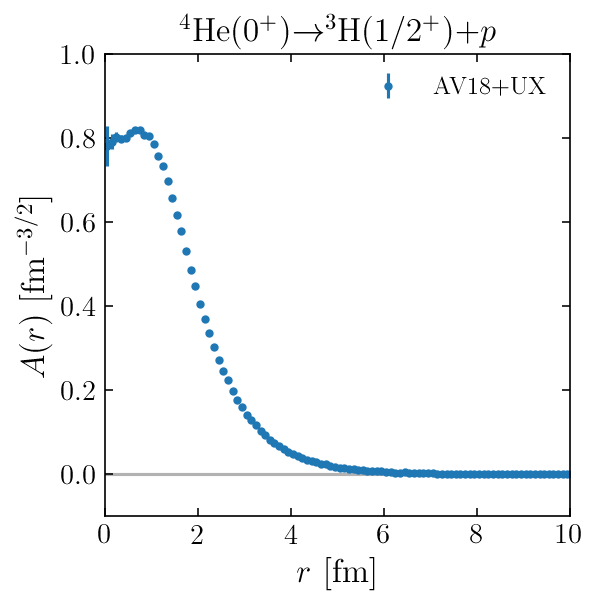

In [8]:
data = np.loadtxt('../data/vmc/spectroscopic_amplitudes/h3p.table.txt')

x_limits = (0, 10)
y_limits = (-0.1, 1)

r_array = data[:, 0]
vmc_overlap_array = data[:, 1]
vmc_errors = data[:, 2]

# Print SF
norm = np.trapz(r_array ** 2 * np.abs(vmc_overlap_array) ** 2, x=r_array)
print(f"VMC SF = {norm:.5f}")

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.errorbar(r_array, vmc_overlap_array, yerr=vmc_errors, label='AV18+UX', ls='',
            marker='.')
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$r$ [fm]", fontsize=16)
ax.set_ylabel(r"$A(r)$ [fm" + r'$^{-3/2}$' + ']', fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
label = r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)" + r"$+p$"
ax.set_title(label, fontsize=16)
plt.show();

## Momentum-space overlaps with unevolved operator

$$
\begin{equation}
A_\alpha(q;\sigma,\tau) = \Bigl[
    \frac{1}{2} \int d\rm{cos{\theta_{\mathbf{q}}}}\,
        \bigl|\,
            \rm{det}(M) \sum_\beta  \phi^\dagger_{\beta}(\mathbf{q};\sigma,\tau) \, M^{-1}_{\beta \alpha}\,
        \bigr|^2\,
\Bigr]^{1/2}
\end{equation}
$$

where $\alpha$ is a s.p. state of $\langle \Psi_0^A(\lambda) \rvert$ with $m_{j_\alpha}$ fixed, $\beta$ and $\phi^\dagger_\beta$ correspond to $\lvert \Phi_0^A(\lambda) \rangle$, and $\rm{M}$ is the overlap matrix.

In [9]:
class SpectroscopicOverlap:
    """Compute the spectroscopic overlap between two nuclei."""
    
    def __init__(self, ws_phi, ws_psi, Z, N, print_M_info=False):
        
        A = Z + N
        
        # Occupied states of | \Phi_0^A(\lambda) >
        self.phi_states = ws_phi.occupied_states
        
        # Occupied states of < \Psi_0^A(\lambda) |
        self.psi_states = []
        i, iZ, iN = 0, 0, 0
        while iZ + iN < A:
            sp_state = ws_psi.sp_states[i]
            if sp_state.m_t == 1/2 and iZ < Z:
                self.psi_states.append(sp_state)
                iZ += 1
            elif sp_state.m_t == -1/2 and iN < N:
                self.psi_states.append(sp_state)
                iN += 1
            i += 1

        # Set Woods-Saxon attributes
        self.dr = ws_phi.dr
        self.ws_phi = ws_phi
        self.ws_psi = ws_psi
        
        # Compute overlap matrix
        self.overlap_matrix = np.zeros((A, A))
        for i, phi in enumerate(self.phi_states):
            for j, psi in enumerate(self.psi_states):
                self.overlap_matrix[i, j] = self.M_ij(phi, psi)
                
        # Inverse of overlap matrix
        self.overlap_matrix_inv = la.inv(self.overlap_matrix)
        
        # Determinant of overlap matrix
        self.overlap_matrix_det = la.det(self.overlap_matrix)
        
        # Print overlap matrix information?
        if print_M_info:
            print("Overlap matrix M_{\phi, \psi}:")
            print(self.overlap_matrix)
            print("\nInverse of overlap matrix M_{\phi, \psi}^-1:")
            print(self.overlap_matrix_inv)
            print("\nDeterminant of overlap matrix det(M):")
            print(self.overlap_matrix_det)
    
    def M_ij(self, phi, psi):
        """Compute the overlap between two s.p. states \phi and \psi."""
        
        # Orthogonality of isospinors and vector spherical harmonics
        cond = (phi.l == psi.l and phi.j == psi.j and phi.m_j == psi.m_j
                and phi.m_t == psi.m_t)
        
        if cond:

            _, u_phi = self.ws_phi.get_wf_rspace(phi)
            _, u_psi = self.ws_psi.get_wf_rspace(psi)
            
            # Overlap is \int_0^\infty dr u_\phi(r) * u_\psi(r)
            return self.dr * np.sum(u_phi * u_psi)
        
        else:
            
            return 0
        
    def alpha_index(self, alpha):
        """Obtain the index of the s.p. state \alpha within the list containing
        occupied states of < \Psi |.
        """
        
        index = 0
        for j, sp_state in enumerate(self.psi_states):
            if sp_state == alpha:
                index = j
                break
                
        return index
    
    def compute_overlap(self, q_array, alpha, sigma, tau):
        """Compute the overlap A(q;\sigma,\tau) where we average over the polar
        angle of q. Units [A] = fm^3/2.
        """
        
        # Meshes for angular integration
        theta_array, theta_weights = gaussian_quadrature_mesh(np.pi, 13)
        
        # 2-D meshgrids
        q_grid, theta_grid = np.meshgrid(q_array, theta_array, indexing='ij')
        _, dtheta_grid = np.meshgrid(q_weights, theta_weights, indexing='ij')
        
        # No dependence on azimuthal angle of q
        phi_grid = np.zeros_like(theta_grid)
        
        overlap_grid = np.zeros_like(q_grid, dtype=complex)
        
        # Jacobian for angular integrations
        jacobian = np.sin(theta_grid) * dtheta_grid
  
        # Index of \alpha in occupied states of < \Psi_0^A(\lambda) |
        jalpha = self.alpha_index(alpha)
        
        # Sum over \beta in | \Phi_0^A(\lambda) >
        for ibeta, beta in enumerate(self.phi_states):
            
            # Single-particle wave function in momentum space
            phi_dagger_grid = np.conj(
                self.ws_phi.psi(beta, q_grid, theta_grid, phi_grid, sigma, tau)
            )

            # Add to overlap
            overlap_grid += (self.overlap_matrix_det * phi_dagger_grid
                             * self.overlap_matrix_inv[ibeta, jalpha])
            
        # Average over polar angle of |A(q_vector)|^2
        overlap_array = 1 / 2 * np.sum(jacobian * np.abs(overlap_grid) ** 2,
                                       axis=-1)
            
        return np.sqrt(overlap_array)

    def spectroscopic_factor(self, n, l, j, m_t, qmax=10.0, qmid=2.0, ntot=120):
        """Compute the spectroscopic factor associated with the overlap:
            \sum_{\sigma, \tau} \int dq q^2 |A_\alpha(q; \sigma, \tau)|^2.
        Fix m_j = j.
        """
        
        factor = 4*np.pi * (2*j+1)

        # Single-particle state with m_j = j
        alpha = SingleParticleState(n, l, j, j, m_t)
        
        # Momentum mesh for integration over q
        q_array, q_weights = momentum_mesh(qmax, qmid, ntot)

        # Sum over spin and isospin projections
        spins = np.array([-1/2, 1/2])
        overlap_squared_array = np.zeros_like(q_array)
        for sigma in spins:
            for tau in spins:
                
                # Compute overlap array A(q; \sigma, \tau)
                overlap_array = self.compute_overlap(q_array, alpha, sigma, tau)
                
                # Add to |A(q; \sigma, \tau)|^2
                overlap_squared_array += np.abs(overlap_array) ** 2

        return factor * np.sum(q_weights * q_array ** 2 * overlap_squared_array)
    
    def compare_to_vmc(self, overlap_array, j):
        """Convert A(q;\sigma,\tau) to have the same normalization as VMC
        overlaps.
        """
        
        factor = np.sqrt(4*np.pi * (2*j+1) * (2*np.pi) ** 3)
        
        return overlap_array * factor

In [10]:
def load_vmc(nucleus_name, print_normalization=True):
    """
    Loads the VMC spectroscopic overlap.
    
    Notes
    -----
    The spectroscopic overlap has the following normalization:
    
        S_\alpha = 1/(2\pi)^3 \int_0^\infty dq q^2 |A(q)|^2,
        
    where A(q) [fm^3/2] is the overlap.
    
    """
    
    vmc_directory = "../data/vmc/spectroscopic_amplitudes/"
    if nucleus_name == 'He4':
        file_name = "h3p_ms.txt"
        index = 0
    else:
        file_name = "b11p3_ms.txt"
        index = 3
    
    f = open(vmc_directory + file_name, 'r')
    data_list = []
    
    for line in f:
        
        unit = line.strip().split()
        if unit[0] == "#":
            pass
        else:
            data_list.append([
                float(unit[0]), float(unit[1+index]),
                float(unit[2+index].strip('(').strip(')'))
            ])
            
    # Convert to NumPy array
    data = np.array(data_list)
    q_array = data[:, 0]
    overlap_array = data[:, 1]
    errors = data[:, 2]
    
    if print_normalization:
        norm = (
            np.trapz(q_array ** 2 * np.abs(overlap_array) ** 2, x=q_array)
            / (2*np.pi) ** 3
        )
        print(f"VMC SF = {norm:.5f}")
    
    return q_array, overlap_array, errors

In [11]:
def check_sf(q_array, q_weights, overlap_array):
    """Check SF using VMC convention."""
    
    return 1 / (2*np.pi) ** 3 * np.sum(q_weights * q_array ** 2
                                       * np.abs(overlap_array) ** 2)

In [12]:
q_array, q_weights = momentum_mesh(10.0, 2.0, 120)

$^{4}$He($0^+$) $\rightarrow$ $^3$H($1/2^+$) $+p$</br>
VMC uses AV18 and UX</br>
SRG uses AV18 at $\lambda=1.5$ fm$^{-1}$

$N = \frac{1}{(2\pi)^3} \int_0^\infty dq q^2 \lvert A(q) \rvert^2$

In [13]:
cg_table = compute_clebsch_gordan_table(3)
ws_phi = WoodsSaxon('He4', 2, 2, cg_table)
ws_psi = WoodsSaxon('H3', 1, 2, cg_table)
Z, N = 2, 2
spectroscopic_overlap = SpectroscopicOverlap(ws_phi, ws_psi, Z, N)
n_alpha, l_alpha, j_alpha, m_t_alpha = 1, 0, 1/2, 1/2
alpha = SingleParticleState(n_alpha, l_alpha, j_alpha, j_alpha, m_t_alpha)

Done calculating Clebsch-Gordan table up to j_max = 3.


VMC SF = 1.62215
SRG SF = 1.70701


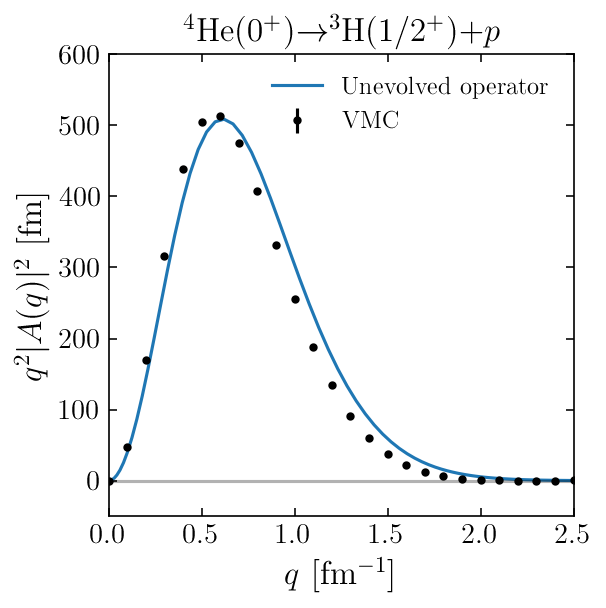

In [14]:
# VMC with AV18+UX
q_vmc, vmc_overlap, vmc_errors = load_vmc('He4')

# Low RG resolution overlap
overlap_array = spectroscopic_overlap.compute_overlap(q_array, alpha, 1/2,
                                                      m_t_alpha)
# Change to VMC normalization
overlap_array = spectroscopic_overlap.compare_to_vmc(overlap_array, j_alpha)
# Check SF
sf = check_sf(q_array, q_weights, overlap_array)
print(f"SRG SF = {sf:.5f}")

x_limits = (0, 2.5)
y_limits = (-50, 600)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')
ax.errorbar(
    q_vmc, vmc_overlap ** 2 * q_vmc ** 2, yerr=vmc_errors * q_vmc ** 2,
    label='VMC', ls='', marker='.', color='black'
)
ax.plot(q_array, q_array ** 2 * np.abs(overlap_array) ** 2,
        label='Unevolved operator')
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
label = r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)" + r"$+p$"
ax.set_title(label, fontsize=16)
plt.show();

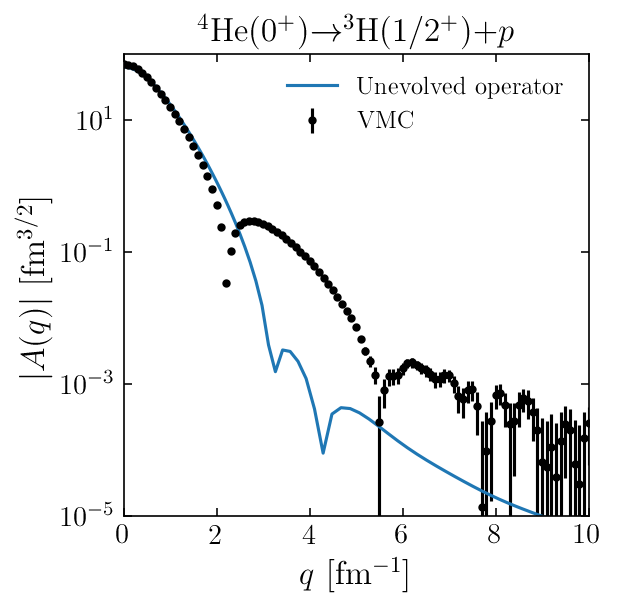

In [15]:
x_limits = (0, 10)
y_limits = (1e-5, 1e2)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('log')
ax.errorbar(q_vmc, np.abs(vmc_overlap), yerr=vmc_errors, label='VMC', ls='',
            marker='.', color='black')
ax.plot(q_array, np.abs(overlap_array), label='Unevolved operator')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$|A(q)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
label = r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)" + r"$+p$"
ax.set_title(label, fontsize=16)
plt.show();

$^{12}$C($0^+$) $\rightarrow$ $^{11}$B($3/2^-$) $+p$</br>
VMC uses AV18 and UX</br>
SRG uses AV18 at $\lambda=1.5$ fm$^{-1}$

In [16]:
ws_phi = WoodsSaxon('C12', 6, 6, cg_table)
ws_psi = WoodsSaxon('B11', 5, 6, cg_table)
Z, N = 6, 6
spectroscopic_overlap = SpectroscopicOverlap(ws_phi, ws_psi, Z, N)
n_alpha, l_alpha, j_alpha, m_t_alpha = 1, 1, 3/2, 1/2
alpha = SingleParticleState(n_alpha, l_alpha, j_alpha, j_alpha, m_t_alpha)

VMC SF = 2.36344
SRG SF = 3.86368
[1.28827022e-01 6.78377049e-01 1.66521282e+00 3.08560946e+00
 4.93219952e+00 7.19239371e+00 9.84628133e+00 1.28643298e+01
 1.62051417e+01 1.98135905e+01 2.36197062e+01 2.75386956e+01
 3.14724236e+01 3.53125499e+01 3.89452953e+01 4.22575465e+01
 4.51437377e+01 4.75127452e+01 4.92939570e+01 5.04417583e+01
 5.09379046e+01 5.07915750e+01 5.00372364e+01 4.87307347e+01
 4.69442039e+01 4.47604401e+01 4.22673340e+01 3.95528339e+01
 3.67007514e+01 3.37875698e+01 3.08802807e+01 2.80351775e+01
 2.52974729e+01 2.27015741e+01 2.02718448e+01 1.80236916e+01
 1.59648332e+01 1.40966363e+01 1.24154285e+01 1.09137236e+01
 9.58131958e+00 8.40624387e+00 7.37554112e+00 6.47590522e+00
 5.69416770e+00 5.01765831e+00 4.43445633e+00 3.93355155e+00
 3.50493325e+00 3.13962388e+00 2.82967215e+00 2.56811778e+00
 2.34893838e+00 2.16698632e+00 2.01792209e+00 1.89814875e+00
 1.80475097e+00 1.73544100e+00 1.68851283e+00 1.66279881e+00
 1.63303105e+00 1.53440149e+00 1.36835049e+00 1.152

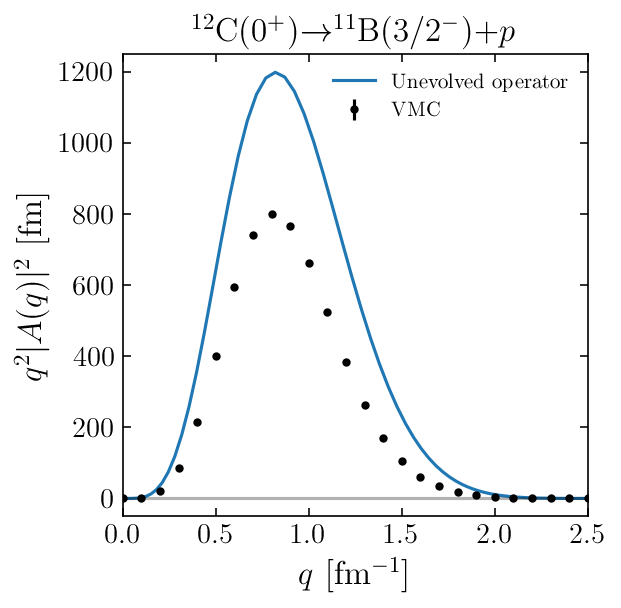

In [17]:
x_limits = (0, 2.5)
y_limits = (-50, 1250)

# VMC overlap
q_vmc, vmc_overlap, vmc_errors = load_vmc('C12')

# Low RG resolution overlap
overlap_array = spectroscopic_overlap.compute_overlap(q_array, alpha, 1/2,
                                                      m_t_alpha)
# Change to VMC normalization
overlap_array = spectroscopic_overlap.compare_to_vmc(overlap_array, j_alpha)
# Check SF
sf = check_sf(q_array, q_weights, overlap_array)
print(f"SRG SF = {sf:.5f}")

### TESTING
print(overlap_array)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')
ax.errorbar(q_vmc, np.abs(vmc_overlap) ** 2 * q_vmc ** 2, yerr=vmc_errors,
            label='VMC', ls='', marker='.', color='black')
ax.plot(q_array, q_array ** 2 * np.abs(overlap_array) ** 2,
        label='Unevolved operator')
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=10, frameon=False)
label = r"$^{12}$C($0^+$)" + r"$\rightarrow$" + r"$^{11}$B($3/2^-$)" + r"$+p$"
ax.set_title(label, fontsize=16)
plt.show();

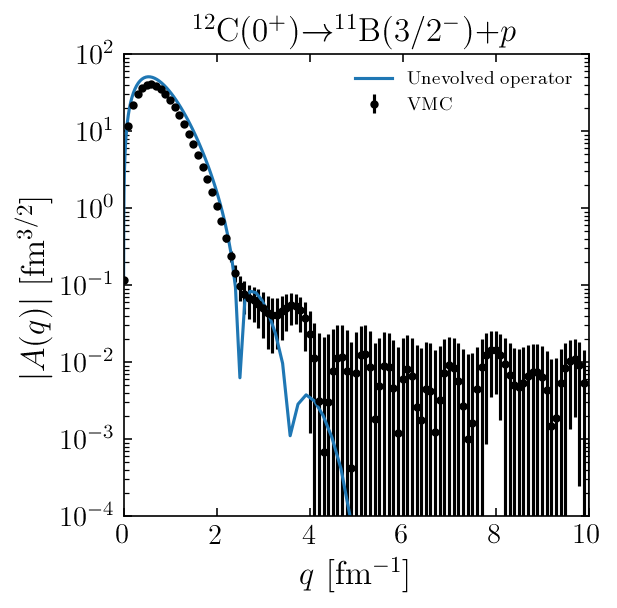

In [18]:
x_limits = (0, 10)
y_limits = (1e-4, 1e2)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('log')
ax.errorbar(q_vmc, np.abs(vmc_overlap), yerr=vmc_errors, label='VMC', ls='',
            marker='.', color='black')
ax.plot(q_array, np.abs(overlap_array), label='Unevolved operator')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$|A(q)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)
ax.legend(loc='upper right', fontsize=9, frameon=False)
label = r"$^{12}$C($0^+$)" + r"$\rightarrow$" + r"$^{11}$B($3/2^-$)" + r"$+p$"
ax.set_title(label, fontsize=16)
plt.show();

### Testing overlap matrix for $A=4$

In [19]:
# ws_phi = WoodsSaxon('He4', 2, 2, cg_table)
# ws_psi = WoodsSaxon('H3', 1, 2, cg_table)
# Z, N = 2, 2
# n, l, j, m_t = 1, 0, 1/2, 1/2

In [20]:
# # Check when \Psi = \Phi
# so = SpectroscopicOverlap(ws_phi, ws_phi, Z, N, print_M_info=True)
# sf = so.spectroscopic_factor(n, l, j, m_t)
# print(f"\nSF = {sf:.5f}")

In [21]:
# # Check when \Psi != \Phi
# so = SpectroscopicOverlap(ws_phi, ws_psi, Z, N, print_M_info=True)
# sf = so.spectroscopic_factor(n, l, j, m_t)
# print(f"\nSF = {sf:.5f}")

### Testing overlap matrix for $A=12$

In [22]:
# ws_phi = WoodsSaxon('C12', 6, 6, cg_table)
# ws_psi = WoodsSaxon('B11', 5, 6, cg_table)
# Z, N = 6, 6

In [23]:
# n, l, j, m_t = 1, 1, 3/2, 1/2

In [24]:
# # Check when \Psi = \Phi
# so = SpectroscopicOverlap(ws_phi, ws_phi, Z, N, print_M_info=True)
# sf = so.spectroscopic_factor(n, l, j, m_t)
# print(f"\nSF = {sf:.5f}")

In [25]:
# # Check when \Psi != \Phi
# so = SpectroscopicOverlap(ws_phi, ws_psi, Z, N, print_M_info=True)
# sf = so.spectroscopic_factor(n, l, j, m_t)
# print(f"\nSF = {sf:.5f}")

In [26]:
# n, l, j, m_t = 1, 1, 1/2, 1/2

In [27]:
# # Check when \Psi = \Phi
# so = SpectroscopicOverlap(ws_phi, ws_phi, Z, N, print_M_info=True)
# sf = so.spectroscopic_factor(n, l, j, m_t)
# print(f"\nSF = {sf:.5f}")

In [28]:
# # Check when \Psi != \Phi
# so = SpectroscopicOverlap(ws_phi, ws_psi, Z, N, print_M_info=True)
# sf = so.spectroscopic_factor(n, l, j, m_t)
# print(f"\nSF = {sf:.5f}")

## Compare averaging over $\Omega_{\mathbf{q}}$ to averaging over $m_j$

$$
\begin{equation}
A_\alpha(q;\sigma,\tau) = \Bigl[
    \frac{1}{2j_{\alpha}+1} \sum_{m_{j_\alpha}}\,
        \bigl|\,
            \rm{det}(M) \sum_\beta  \phi^\dagger_{\beta}(\mathbf{q};\sigma,\tau) \, M^{-1}_{\beta \alpha}\,
        \bigr|^2\,
\Bigr]^{1/2}
\end{equation}
$$

where $\mathbf{q}=q\hat{z}$, $\alpha$ is a s.p. state of $\langle \Psi_0^A(\lambda) \rvert$, $\beta$ and $\phi^\dagger_\beta$ correspond to $\lvert \Phi_0^A(\lambda) \rangle$, and $\rm{M}$ is the overlap matrix.

In [29]:
class SpectroscopicOverlap2:
    """Compute the spectroscopic overlap between two nuclei."""
    
    def __init__(self, ws_phi, ws_psi, Z, N, print_M_info=False):
        
        A = Z + N
        
        # Occupied states of | \Phi_0^A(\lambda) >
        self.phi_states = ws_phi.occupied_states
        
        # Occupied states of < \Psi_0^A(\lambda) |
        self.psi_states = []
        i, iZ, iN = 0, 0, 0
        while iZ + iN < A:
            sp_state = ws_psi.sp_states[i]
            if sp_state.m_t == 1/2 and iZ < Z:
                self.psi_states.append(sp_state)
                iZ += 1
            elif sp_state.m_t == -1/2 and iN < N:
                self.psi_states.append(sp_state)
                iN += 1
            i += 1

        # Set Woods-Saxon attributes
        self.dr = ws_phi.dr
        self.ws_phi = ws_phi
        self.ws_psi = ws_psi
        
        # Compute overlap matrix
        self.overlap_matrix = np.zeros((A, A))
        for i, phi in enumerate(self.phi_states):
            for j, psi in enumerate(self.psi_states):
                self.overlap_matrix[i, j] = self.M_ij(phi, psi)
                
        # Inverse of overlap matrix
        self.overlap_matrix_inv = la.inv(self.overlap_matrix)
        
        # Determinant of overlap matrix
        self.overlap_matrix_det = la.det(self.overlap_matrix)
        
        # Print overlap matrix information?
        if print_M_info:
            print("Overlap matrix M_{\phi, \psi}:")
            print(self.overlap_matrix)
            print("\nInverse of overlap matrix M_{\phi, \psi}^-1:")
            print(self.overlap_matrix_inv)
            print("\nDeterminant of overlap matrix det(M):")
            print(self.overlap_matrix_det)
    
    def M_ij(self, phi, psi):
        """Compute the overlap between two s.p. states \phi and \psi."""
        
        # Orthogonality of isospinors and vector spherical harmonics
        cond = (phi.l == psi.l and phi.j == psi.j and phi.m_j == psi.m_j
                and phi.m_t == psi.m_t)
        
        if cond:

            _, u_phi = self.ws_phi.get_wf_rspace(phi)
            _, u_psi = self.ws_psi.get_wf_rspace(psi)
            
            # Overlap is \int_0^\infty dr u_\phi(r) * u_\psi(r)
            return self.dr * np.sum(u_phi * u_psi)
        
        else:
            
            return 0
        
    def alpha_index(self, alpha):
        """Obtain the index of the s.p. state \alpha within the list containing
        occupied states of < \Psi |.
        """
        
        index = 0
        for j, sp_state in enumerate(self.psi_states):
            if sp_state == alpha:
                index = j
                break
                
        return index
    
    def compute_overlap(self, q_array, n, l, j, m_t, sigma, tau):
        """Compute the overlap A(q;\sigma,\tau) where we average over m_j.
        Units [A] = fm^3/2.
        """
        
        # Angles are set to 0 since q_vector = q * \hat{z}
        theta_array = np.zeros_like(q_array)
        phi_array = np.zeros_like(q_array)
    
        overlap_array = np.zeros_like(q_array, dtype=complex)
        
        # Average over m_j_\alpha
        m_j_array = np.arange(-j, j + 1, 1)
        for m_j in m_j_array:
            
            alpha = SingleParticleState(n, l, j, m_j, m_t)
            
            # Index of \alpha in occupied states of < \Psi_0^A(\lambda) |
            jalpha = self.alpha_index(alpha)
            
            # Sum over \beta in | \Phi_0^A(\lambda) >
            overlap_mj_array = np.zeros_like(q_array, dtype=complex)
            for ibeta, beta in enumerate(self.phi_states):
            
                # Single-particle wave function in momentum space
                phi_dagger_array = np.conj(
                    self.ws_phi.psi(beta, q_array, theta_array, phi_array,
                                    sigma, tau)
                )

                # Add to overlap
                overlap_mj_array += (
                    self.overlap_matrix_det * phi_dagger_array
                    * self.overlap_matrix_inv[ibeta, jalpha]
                )
            
            # Average over m_j
            overlap_array += np.abs(overlap_mj_array) ** 2
            
        return np.sqrt(overlap_array / (2*j+1))

    def spectroscopic_factor(self, n, l, j, m_t, qmax=10.0, qmid=2.0, ntot=120):
        """Compute the spectroscopic factor associated with the overlap:
            \sum_{\sigma, \tau} \int dq q^2 |A_\alpha(q; \sigma, \tau)|^2.
        Fix m_j = j.
        """
        
        factor = 4*np.pi * (2*j+1)
        
        # Momentum mesh for integration over q
        q_array, q_weights = momentum_mesh(qmax, qmid, ntot)

        # Sum over spin and isospin projections
        spins = np.array([-1/2, 1/2])
        overlap_squared_array = np.zeros_like(q_array)
        for sigma in spins:
            for tau in spins:
                
                # Compute overlap array A(q; \sigma, \tau)
                overlap_array = self.compute_overlap(q_array, n, l, j, m_t,
                                                     sigma, tau)
                
                # Add to |A(q; \sigma, \tau)|^2
                overlap_squared_array += np.abs(overlap_array) ** 2

        return factor * np.sum(q_weights * q_array ** 2 * overlap_squared_array)
    
    def compare_to_vmc(self, overlap_array, j):
        """Convert A(q;\sigma,\tau) to have the same normalization as VMC
        overlaps.
        """
        
        # Factor of 2 for \sigma = +1/2 or -1/2
        factor = np.sqrt(2 * 4*np.pi * (2*j+1) * (2*np.pi) ** 3)
        
        return overlap_array * factor

In [30]:
def compare_two_methods(
        nucleus_name, Z, N, n_alpha, l_alpha, j_alpha, cg_table,
        x_limits=(0,2.5), y_limits=(-50,600)
):
    """Compare the two methods of computing the spectroscopic overlap without
    evolving the operator.
    """
    
    ws_phi = WoodsSaxon(nucleus_name, Z, N, cg_table)
    if nucleus_name == 'He4':
        ws_psi = WoodsSaxon('H3', Z-1, N, cg_table)
        label = (r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)"
                 + r"$+p$")
    elif nucleus_name == 'C12':
        ws_psi = WoodsSaxon('B11', Z-1, N, cg_table)
        label = (r"$^{12}$C($0^+$)" + r"$\rightarrow$" + r"$^{11}$B($3/2^+$)"
                 + r"$+p$")
        
    m_t_alpha = 1/2  # Fixing to proton case
    alpha = SingleParticleState(n_alpha, l_alpha, j_alpha, j_alpha, m_t_alpha)

    # Averaging over q and fixing m_j
    spectroscopic_q_overlap = SpectroscopicOverlap(ws_phi, ws_psi, Z, N)
    overlap_q_array = spectroscopic_q_overlap.compute_overlap(
        q_array, alpha, 1/2, m_t_alpha
    )
    overlap_q_array = spectroscopic_q_overlap.compare_to_vmc(overlap_q_array,
                                                             j_alpha)
    sf_q = check_sf(q_array, q_weights, overlap_q_array)
    print(f"Averaging over q and fixing m_j:\nSF = {sf_q:.5f}\n")
    
    # Averaging over m_j and fixing q_vector = q * \hat{z}
    spectroscopic_mj_overlap = SpectroscopicOverlap2(ws_phi, ws_psi, Z, N)
    overlap_mj_array = spectroscopic_mj_overlap.compute_overlap(
        q_array, n_alpha, l_alpha, j_alpha, m_t_alpha, 1/2, m_t_alpha
    )
    overlap_mj_array = spectroscopic_mj_overlap.compare_to_vmc(overlap_mj_array,
                                                               j_alpha)
    sf_mj = check_sf(q_array, q_weights, overlap_mj_array)
    print(f"Averaging over m_j and fixing q:\nSF = {sf_mj:.5f}\n")

    ### LEFT OFF HERE
    
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    ax.set_yscale('linear')
    ax.plot(q_array, q_array ** 2 * np.abs(overlap_q_array) ** 2,
            label=r'Average over $\theta_q$')
    ax.plot(q_array, q_array ** 2 * np.abs(overlap_mj_array) ** 2,
            label=r'Average over $m_j$', ls='dashed')
    ax.axhline(y=0, alpha=0.3, color='black')
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
    ax.legend(loc='upper right', fontsize=12, frameon=False)
    ax.set_title(label, fontsize=16);

Averaging over q and fixing m_j:
SF = 1.70701

Averaging over m_j and fixing q:
SF = 1.70701



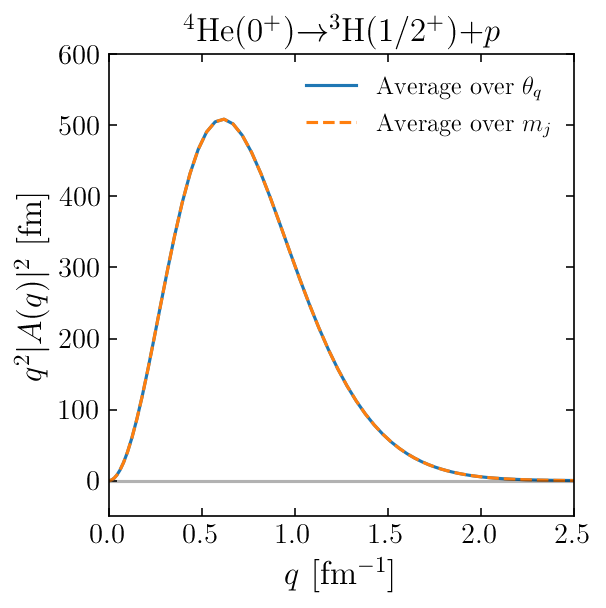

In [31]:
# Test 4He
compare_two_methods('He4', 2, 2, 1, 0, 1/2, cg_table)

Averaging over q and fixing m_j:
SF = 3.86368

Averaging over m_j and fixing q:
SF = 3.86368



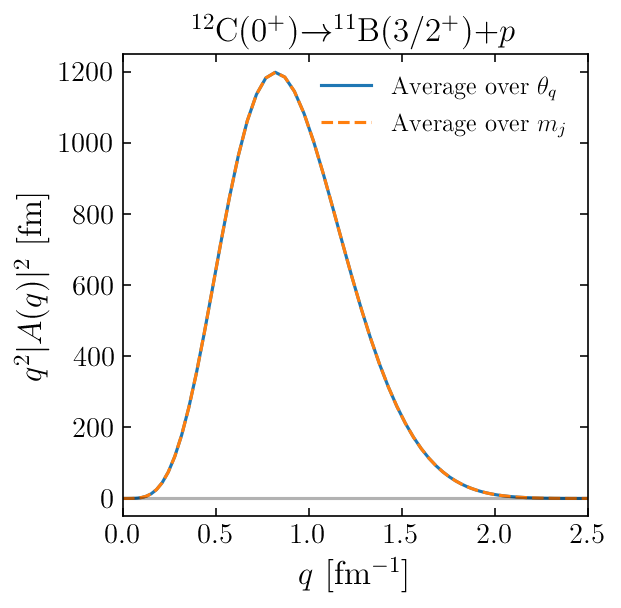

In [32]:
# Test 12C
compare_two_methods('C12', 6, 6, 1, 1, 3/2, cg_table, y_limits=(-50,1250))

## Momentum-space overlaps with evolved operator

In [33]:
# Settings for operator evolution
kvnn = 6
lamb = 1.5
channels = ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1')

### Test $^4$He overlap

In [34]:
nucleus_name, Z, N = 'He4', 2, 2
n, l, j, m_t = 1, 0, 1/2, 1/2  # 1s_{1/2}
so = SO(nucleus_name, Z, N, kvnn, lamb, channels)

filename = (replace_periods(f"{nucleus_name}_proton_n{n}_l{l}_j{2*j}"
                            f"_overlap_kvnn_{kvnn}_lamb_{lamb}") + '.txt')
q_array, q_weights, overlap_array, errors, ipm_array = so.load(filename)

# Check SF
sf_srg = check_sf(q_array, q_weights, overlap_array)
print(f"SRG SF = {sf_srg:.5f}")
sf_ipm = check_sf(q_array, q_weights, ipm_array)
print(f"Unevolved SF = {sf_ipm:.5f}")

# VMC with AV18+UX
q_vmc, vmc_overlap, vmc_errors = load_vmc(nucleus_name)

# Plot label
label = r"$^{4}$He($0^+$)" + r"$\rightarrow$" + r"$^3$H($1/2^+$)" + r"$+p$"

Done calculating Clebsch-Gordan table up to j_max = 4.
SRG SF = 1.56986
Unevolved SF = 1.70701
VMC SF = 1.62215


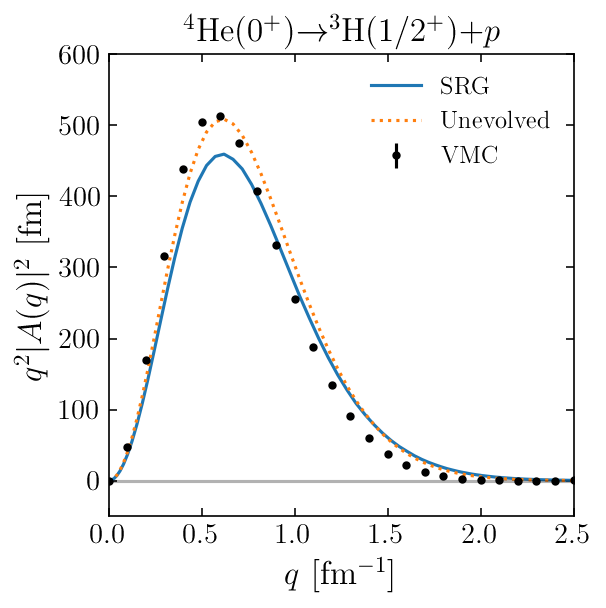

In [35]:
x_limits = (0, 2.5)
y_limits = (-50, 600)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')
ax.errorbar(
    q_vmc, vmc_overlap ** 2 * q_vmc ** 2, yerr=vmc_errors * q_vmc ** 2,
    label='VMC', ls='', marker='.', color='black'
)
ax.plot(q_array, q_array ** 2 * np.abs(overlap_array) ** 2, label='SRG')
ax.plot(q_array, q_array ** 2 * np.abs(ipm_array) ** 2, label='Unevolved',
        ls='dotted')
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
ax.set_title(label, fontsize=16)
plt.show();

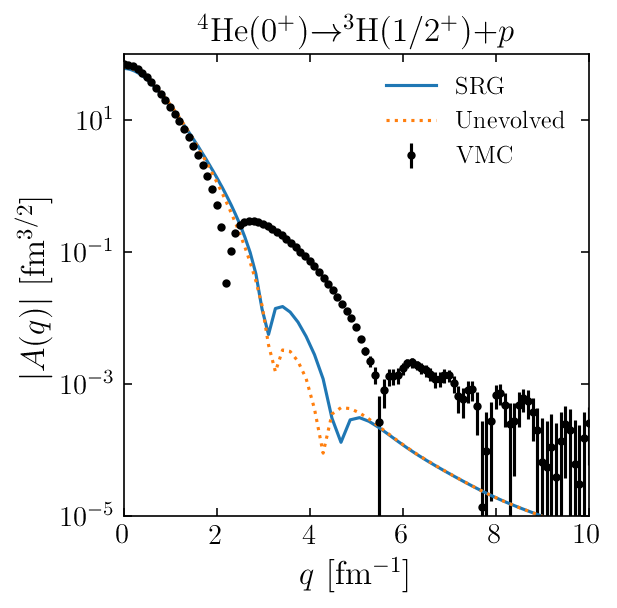

In [36]:
x_limits = (0, 10)
y_limits = (1e-5, 1e2)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('log')
ax.errorbar(q_vmc, np.abs(vmc_overlap), yerr=vmc_errors, label='VMC', ls='',
            marker='.', color='black')
ax.plot(q_array, np.abs(overlap_array), label='SRG')
ax.plot(q_array, np.abs(ipm_array), label='Unevolved', ls='dotted')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$|A(q)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
ax.set_title(label, fontsize=16)
plt.show();

### Test $^{12}$C overlap

In [37]:
nucleus_name, Z, N = 'C12', 6, 6
n, l, j, m_t = 1, 1, 3/2, 1/2  # 1p_{3/2}
so = SO(nucleus_name, Z, N, kvnn, lamb, channels)

filename = (replace_periods(f"{nucleus_name}_proton_n{n}_l{l}_j{2*j}"
                            f"_overlap_kvnn_{kvnn}_lamb_{lamb}") + '.txt')
q_array, q_weights, overlap_array, errors, ipm_array = so.load(filename)

# Check SF
sf_srg = check_sf(q_array, q_weights, overlap_array)
print(f"SRG SF = {sf_srg:.5f}")
sf_ipm = check_sf(q_array, q_weights, ipm_array)
print(f"Unevolved SF = {sf_ipm:.5f}")

# VMC with AV18+UX
q_vmc, vmc_overlap, vmc_errors = load_vmc(nucleus_name)

# Plot label
label = r"$^{12}$C($0^+$)" + r"$\rightarrow$" + r"$^{11}$B($3/2^+$)" + r"$+p$"

Done calculating Clebsch-Gordan table up to j_max = 4.
SRG SF = 3.16468
Unevolved SF = 3.46237
VMC SF = 2.36344


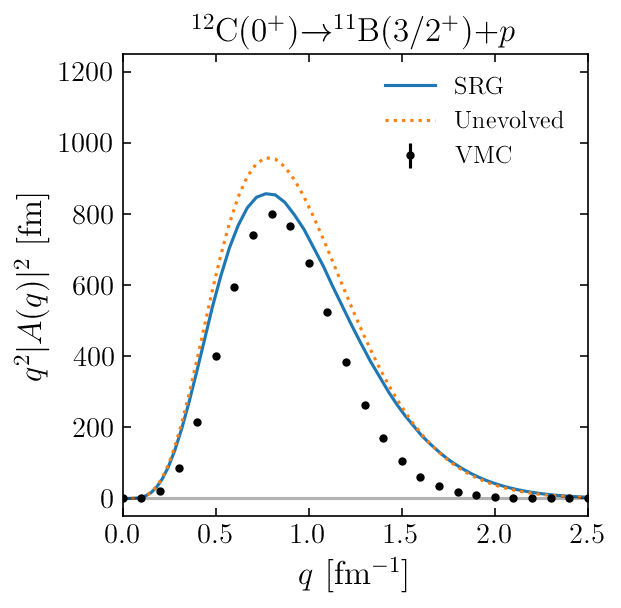

In [38]:
x_limits = (0, 2.5)
y_limits = (-50, 1250)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('linear')
ax.errorbar(
    q_vmc, vmc_overlap ** 2 * q_vmc ** 2, yerr=vmc_errors * q_vmc ** 2,
    label='VMC', ls='', marker='.', color='black'
)
ax.plot(q_array, q_array ** 2 * np.abs(overlap_array) ** 2, label='SRG')
ax.plot(q_array, q_array ** 2 * np.abs(ipm_array) ** 2, label='Unevolved',
        ls='dotted')
ax.axhline(y=0, alpha=0.3, color='black')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$q^2 |A(q)|^2$ [fm]", fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
ax.set_title(label, fontsize=16)
plt.show();

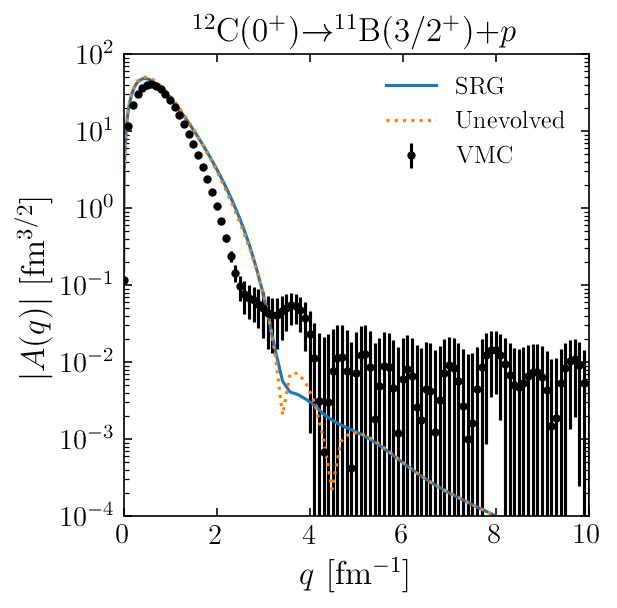

In [39]:
x_limits = (0, 10)
y_limits = (1e-4, 1e2)

plt.close('all')
f, ax = plt.subplots(figsize=(4, 4))
ax.set_yscale('log')
ax.errorbar(q_vmc, np.abs(vmc_overlap), yerr=vmc_errors, label='VMC', ls='',
            marker='.', color='black')
ax.plot(q_array, np.abs(overlap_array), label='SRG')
ax.plot(q_array, np.abs(ipm_array), label='Unevolved', ls='dotted')
ax.set_xlim(x_limits)
ax.set_ylim(y_limits)
ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
ax.set_ylabel(r"$|A(q)|$ [fm" + r'$^{3/2}$' + ']', fontsize=16)
ax.legend(loc='upper right', fontsize=12, frameon=False)
ax.set_title(label, fontsize=16)
plt.show();